In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
app_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv("credit_record.csv")

# Functions

In [3]:
## check missing data
def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    mis_table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return mis_table

In [4]:
def detect_outlier(df):
    for i in df.describe().columns[1:]: # chỉ lấy những cột numeric, bỏ cột ID
        Q1=df.describe().at['25%',i]
        Q3=df.describe().at['75%',i]
        IQR=Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        print(f'Outlier Report of {i}')
        print(f'Lower bound = {lower_bound}')
        print(f'Upper bound = {upper_bound}')

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(dpi=300)
    #plt.figure(figsize=(10,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [8]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'binned' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

# EDA application_record

In [9]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [10]:
app_df.describe().columns

Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS'],
      dtype='object')

In [11]:
app_df.shape

(438557, 18)

In [12]:
app_df['ID'].nunique()

438510

In [13]:
#tạo cột age
app_df['AGE'] = (-app_df['DAYS_BIRTH']//365).round(0)
app_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,32
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,32
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,58
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,52
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,62
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,43
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,22
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,59


In [14]:
#tạo cột work_year
app_df['WORK_YEAR'] = (-app_df['DAYS_EMPLOYED']//365).round(0)
app_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WORK_YEAR
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,32,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,58,3
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,52,8
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,52,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,62,-1001
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,43,8
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,22,1
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,59,-1001


In [15]:
app_df = app_df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1)

### check missing data

In [16]:
check_missing_data(app_df)

,Total,Percent
OCCUPATION_TYPE,134203,30.601039
ID,0,0.000000
CODE_GENDER,0,0.000000
AGE,0,0.000000
CNT_FAM_MEMBERS,0,0.000000
FLAG_EMAIL,0,0.000000
FLAG_PHONE,0,0.000000
FLAG_WORK_PHONE,0,0.000000
FLAG_MOBIL,0,0.000000
NAME_HOUSING_TYPE,0,0.000000


In [17]:
app_df[app_df['OCCUPATION_TYPE'].isnull()]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WORK_YEAR
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,32,12
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,NaN,1.0,61,-1001
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,NaN,1.0,61,-1001
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,NaN,1.0,61,-1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438549,6840098,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,1,0,0,0,NaN,1.0,62,-1001
438550,6840100,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,1,0,0,0,NaN,1.0,62,-1001
438551,6840102,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,1,0,0,0,NaN,1.0,62,-1001
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,1,0,0,0,NaN,1.0,62,-1001


In [18]:
list_income_type = app_df[app_df['OCCUPATION_TYPE'].isnull()]['NAME_INCOME_TYPE'].value_counts().index
list_income_type

Index(['Pensioner', 'Working', 'Commercial associate', 'State servant',
       'Student'],
      dtype='object')

In [19]:
app_df[app_df['NAME_INCOME_TYPE'] == 'Pensioner']['OCCUPATION_TYPE'].value_counts().idxmax()

'Core staff'

In [20]:
for inc_type in list_income_type:
    app_df.loc[((app_df['NAME_INCOME_TYPE'] == inc_type) & (app_df['OCCUPATION_TYPE'].isnull())), ['OCCUPATION_TYPE']] = app_df[app_df['NAME_INCOME_TYPE'] == inc_type]['OCCUPATION_TYPE'].value_counts().idxmax()

In [22]:
check_missing_data(app_df)

,Total,Percent
ID,0,0.0
CODE_GENDER,0,0.0
AGE,0,0.0
CNT_FAM_MEMBERS,0,0.0
OCCUPATION_TYPE,0,0.0
FLAG_EMAIL,0,0.0
FLAG_PHONE,0,0.0
FLAG_WORK_PHONE,0,0.0
FLAG_MOBIL,0,0.0
NAME_HOUSING_TYPE,0,0.0


In [23]:
app_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WORK_YEAR
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,58,3
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,1,0,0,0,Core staff,1.0,62,-1001
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,0,0,Laborers,1.0,43,8
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,1,1,0,0,Sales staff,1.0,22,1
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Core staff,2.0,59,-1001


### check duplicates

In [24]:
app_df.duplicated().sum()

0

### correlation
cnt_children vs cnt_fam_member have quite high correlation (>cutpoff = 0.5, Cohen(1988), and its actual meaning is the same too -> drop

<AxesSubplot:>

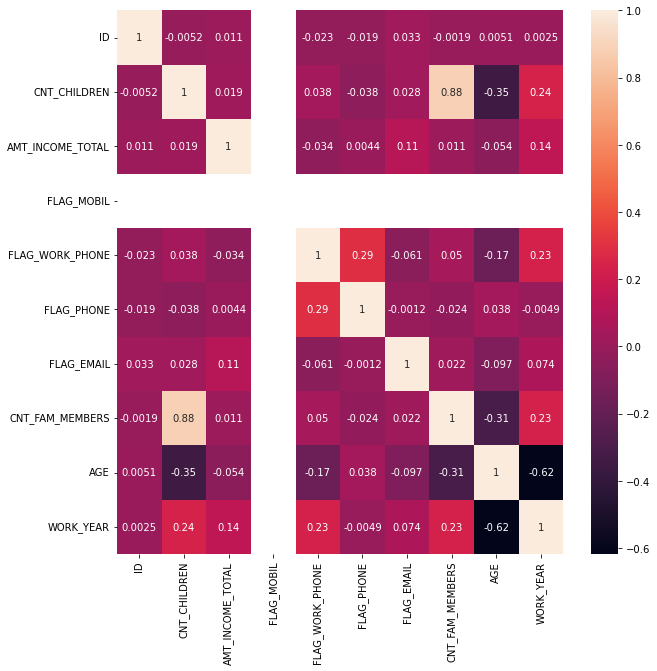

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(app_df.corr(), annot=True)

In [26]:
app_df = app_df.drop(columns=['CNT_CHILDREN'])
app_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WORK_YEAR
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,58,3
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,1,0,0,0,Core staff,1.0,62,-1001
438553,6840222,F,N,N,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,0,0,Laborers,1.0,43,8
438554,6841878,F,N,N,54000.0,Commercial associate,Higher education,Single / not married,With parents,1,1,0,0,Sales staff,1.0,22,1
438555,6842765,F,N,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Core staff,2.0,59,-1001


### detect outlier 

In [27]:
detect_outlier(app_df)

Outlier Report of AMT_INCOME_TOTAL
Lower bound = -33750.0
Upper bound = 380250.0
Outlier Report of FLAG_MOBIL
Lower bound = 1.0
Upper bound = 1.0
Outlier Report of FLAG_WORK_PHONE
Lower bound = 0.0
Upper bound = 0.0
Outlier Report of FLAG_PHONE
Lower bound = -1.5
Upper bound = 2.5
Outlier Report of FLAG_EMAIL
Lower bound = 0.0
Upper bound = 0.0
Outlier Report of CNT_FAM_MEMBERS
Lower bound = 0.5
Upper bound = 4.5
Outlier Report of AGE
Lower bound = 5.5
Upper bound = 81.5
Outlier Report of WORK_YEAR
Lower bound = -9.5
Upper bound = 18.5


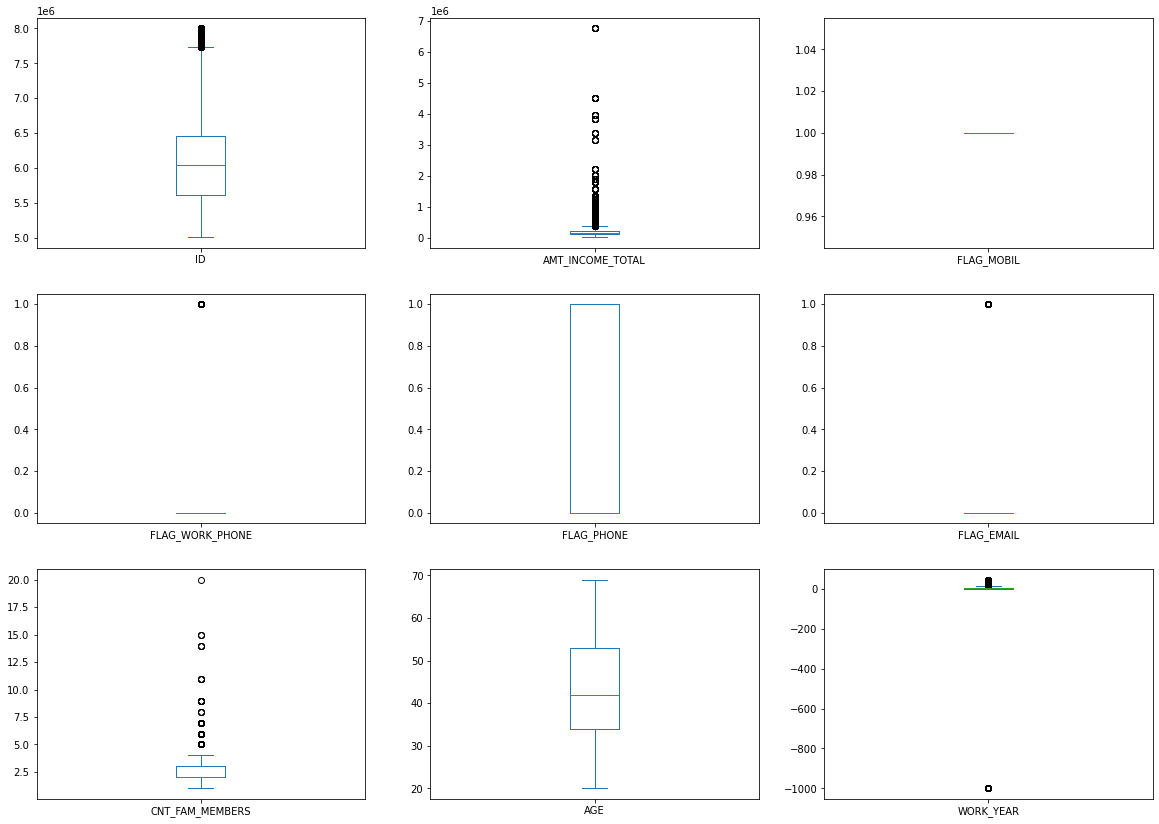

In [28]:
app_df.plot(kind='box', subplots=True, layout=(12,3), sharex=False, sharey=False, figsize=(20, 60))
plt.show()

In [29]:
app_df['CNT_FAM_MEMBERS'].value_counts()

2.0     233891
1.0      84492
3.0      77128
4.0      37356
5.0       5081
6.0        459
7.0        124
9.0          9
11.0         5
14.0         4
8.0          4
15.0         3
20.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [30]:
# remove outlier for AMT_INCOME_TOTAL
app_df = app_df[app_df['AMT_INCOME_TOTAL']<=380250][app_df['WORK_YEAR']<18.5][app_df['CNT_FAM_MEMBERS'] <4.5].reset_index()
app_df = app_df.drop(columns='index', axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\4062897733.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app_df = app_df[app_df['AMT_INCOME_TOTAL']<=380250][app_df['WORK_YEAR']<18.5][app_df['CNT_FAM_MEMBERS'] <4.5].reset_index()


array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'AMT_INCOME_TOTAL'}>,
        <AxesSubplot:title={'center':'FLAG_WORK_PHONE'}>],
       [<AxesSubplot:title={'center':'FLAG_PHONE'}>,
        <AxesSubplot:title={'center':'FLAG_EMAIL'}>,
        <AxesSubplot:title={'center':'CNT_FAM_MEMBERS'}>],
       [<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'WORK_YEAR'}>, <AxesSubplot:>]],
      dtype=object)

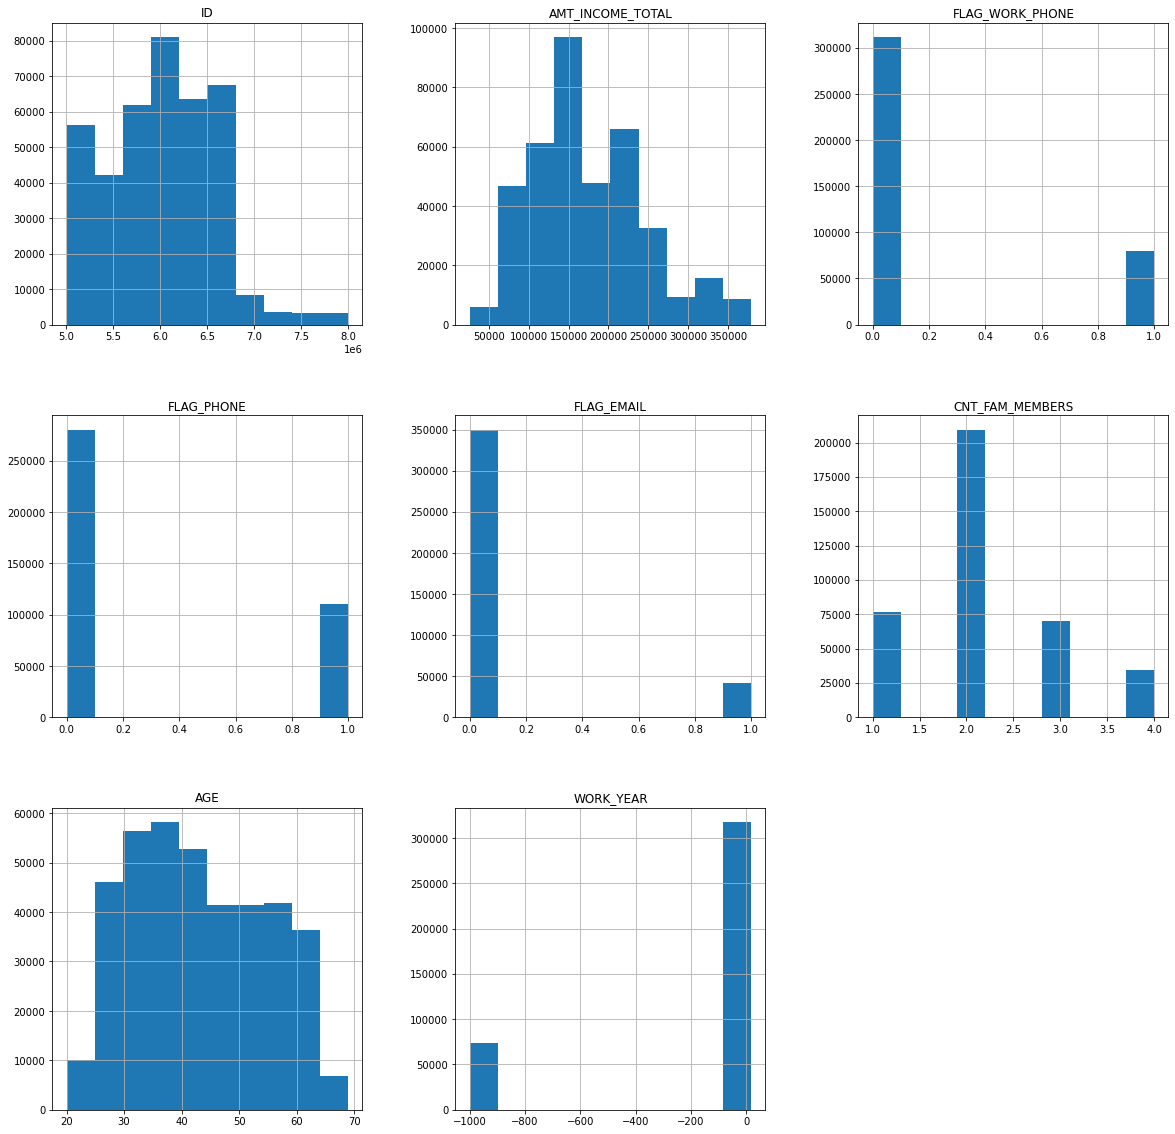

In [39]:
app_df.hist(figsize=(20, 20))

In [33]:
app_df['FLAG_PHONE'].value_counts()

0    280410
1    110753
Name: FLAG_PHONE, dtype: int64

In [34]:
app_df['FLAG_EMAIL'].value_counts()

0    350130
1     41033
Name: FLAG_EMAIL, dtype: int64

In [35]:
app_df['FLAG_MOBIL'].value_counts()

1    391163
Name: FLAG_MOBIL, dtype: int64

In [36]:
app_df = app_df.drop(columns='FLAG_MOBIL', axis=1)

In [37]:
app_df['NAME_INCOME_TYPE'].value_counts() #drop Student because of too little

Working                 200744
Commercial associate     87249
Pensioner                73861
State servant            29292
Student                     17
Name: NAME_INCOME_TYPE, dtype: int64

<AxesSubplot:>

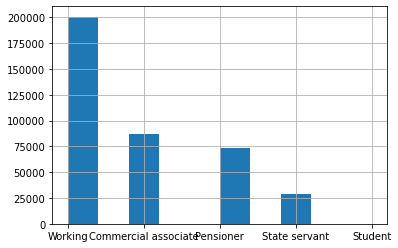

In [38]:
app_df['NAME_INCOME_TYPE'].hist()

In [40]:
app_df = app_df[app_df['NAME_INCOME_TYPE'] != 'Student']
app_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WORK_YEAR
0,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,58,3
1,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52,8
2,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52,8
3,5008810,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52,8
4,5008811,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391158,6840104,M,N,Y,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,0,0,0,Core staff,1.0,62,-1001
391159,6840222,F,N,N,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,0,0,0,Laborers,1.0,43,8
391160,6841878,F,N,N,54000.0,Commercial associate,Higher education,Single / not married,With parents,1,0,0,Sales staff,1.0,22,1
391161,6842765,F,N,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,0,0,0,Core staff,2.0,59,-1001


In [41]:
app_df['NAME_INCOME_TYPE'].value_counts()

Working                 200744
Commercial associate     87249
Pensioner                73861
State servant            29292
Name: NAME_INCOME_TYPE, dtype: int64

In [42]:
app_df['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    273114
Higher education                 100375
Incomplete higher                 13510
Lower secondary                    3866
Academic degree                     281
Name: NAME_EDUCATION_TYPE, dtype: int64

In [43]:
app_df['NAME_FAMILY_STATUS'].value_counts()

Married                 265055
Single / not married     50815
Civil marriage           33297
Separated                24172
Widow                    17807
Name: NAME_FAMILY_STATUS, dtype: int64

In [44]:
app_df['NAME_HOUSING_TYPE'].value_counts()

House / apartment      350223
With parents            18092
Municipal apartment     12497
Rented apartment         5598
Office apartment         3377
Co-op apartment          1359
Name: NAME_HOUSING_TYPE, dtype: int64

In [45]:
app_df['FLAG_WORK_PHONE'].value_counts()

0    311723
1     79423
Name: FLAG_WORK_PHONE, dtype: int64

In [46]:
app_df['CNT_FAM_MEMBERS'].value_counts()

2.0    209440
1.0     76807
3.0     70206
4.0     34693
Name: CNT_FAM_MEMBERS, dtype: int64

In [47]:
app_df['AMT_INCOME_TOTAL'].describe()

count    391146.000000
mean     172837.022196
std       70528.710115
min       26100.000000
25%      117000.000000
50%      157500.000000
75%      225000.000000
max      378900.000000
Name: AMT_INCOME_TOTAL, dtype: float64

# EDA credit_record

In [48]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### check missing data

In [49]:
check_missing_data(credit_df)

,Total,Percent
ID,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0


### check duplicates

In [50]:
credit_df.duplicated().sum()

0

### correlation
kcan vì có quá ít cột

### detect outlier
no matter

In [51]:
detect_outlier(credit_df)

Outlier Report of MONTHS_BALANCE
Lower bound = -62.0
Upper bound = 26.0


<AxesSubplot:>

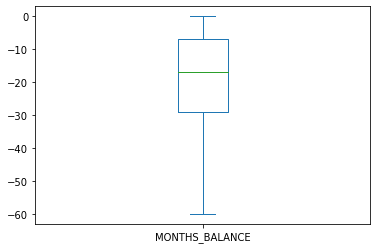

In [52]:
credit_df['MONTHS_BALANCE'].plot(kind='box')

In [53]:
credit_df['ID'].nunique()

45985

In [54]:
##drop months_balance vì vô nghĩa
credit_df = credit_df.drop(columns= 'MONTHS_BALANCE', axis=1)

In [55]:
credit_df['STATUS'].value_counts(normalize=True)

C    0.421554
0    0.365372
X    0.199537
1    0.010576
5    0.001615
2    0.000828
3    0.000305
4    0.000213
Name: STATUS, dtype: float64

In [56]:
credit_df['STATUS'][credit_df["STATUS"] == 'C'] = -1
credit_df['STATUS'][credit_df["STATUS"] == 'X'] = -1

C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\3598881250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_df['STATUS'][credit_df["STATUS"] == 'C'] = -1
C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\3598881250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_df['STATUS'][credit_df["STATUS"] == 'X'] = -1


In [57]:
credit_df['STATUS'].value_counts()

-1    651261
0     383120
1      11090
5       1693
2        868
3        320
4        223
Name: STATUS, dtype: int64

In [58]:
credit_df['STATUS'] = credit_df.STATUS.apply(lambda x : int(x))
credit_df['TARGET'] = credit_df.STATUS.apply(lambda x : 0 if x>=3 else 1)
credit_df.drop(['STATUS'],axis = 1,inplace = True)

In [60]:
credit_df['TARGET'].value_counts(normalize=True) ## imbalanced

1    0.997868
0    0.002132
Name: TARGET, dtype: float64

# Merge 2 datasets

## Check balancing

In [61]:
df = pd.merge(app_df, credit_df, how= 'inner', on= 'ID')
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,WORK_YEAR,TARGET
0,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,58,3,1
1,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,58,3,1
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,58,3,1
3,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,58,3,1
4,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,58,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689253,5150337,M,N,Y,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,25,3,1
689254,5150337,M,N,Y,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,25,3,1
689255,5150337,M,N,Y,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,25,3,1
689256,5150337,M,N,Y,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,0,0,0,Laborers,1.0,25,3,1


In [62]:
df.duplicated().sum()

656424

In [63]:
df = df.drop_duplicates()

In [64]:
check_missing_data(df)

,Total,Percent
ID,0,0.0
FLAG_WORK_PHONE,0,0.0
WORK_YEAR,0,0.0
AGE,0,0.0
CNT_FAM_MEMBERS,0,0.0
OCCUPATION_TYPE,0,0.0
FLAG_EMAIL,0,0.0
FLAG_PHONE,0,0.0
NAME_HOUSING_TYPE,0,0.0
CODE_GENDER,0,0.0


In [90]:
df['TARGET'].value_counts() #severe imbalance

1    32571
0      263
Name: TARGET, dtype: int64

In [91]:
df['TARGET'].value_counts(normalize=True) 

1    0.99199
0    0.00801
Name: TARGET, dtype: float64

# Calculate information value

In [65]:
#create IV score table
ivtable=pd.DataFrame(df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['TARGET','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

In [66]:
ivtable

,variable,IV
1,CODE_GENDER,None
2,FLAG_OWN_CAR,None
3,FLAG_OWN_REALTY,None
4,AMT_INCOME_TOTAL,None
5,NAME_INCOME_TYPE,None
6,NAME_EDUCATION_TYPE,None
7,NAME_FAMILY_STATUS,None
8,NAME_HOUSING_TYPE,None
9,FLAG_WORK_PHONE,None
10,FLAG_PHONE,None


### Binary variables 

In [67]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'AGE',
       'WORK_YEAR', 'TARGET'],
      dtype='object')

In [68]:
iv, data = calc_iv(df, 'CODE_GENDER', 'TARGET')
ivtable.loc[ivtable['variable']=='CODE_GENDER','IV']=iv

This variable's IV is: 0.004263341449129162
F    21985
M    10849
Name: CODE_GENDER, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


In [69]:
iv, data = calc_iv(df, 'FLAG_OWN_CAR', 'TARGET')
ivtable.loc[ivtable['variable']=='FLAG_OWN_CAR','IV']=iv
iv

This variable's IV is: 0.00581037457811834
N    20534
Y    12300
Name: FLAG_OWN_CAR, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


0.00581037457811834

In [70]:
iv, data = calc_iv(df, 'FLAG_OWN_REALTY', 'TARGET')
ivtable.loc[ivtable['variable']=='FLAG_OWN_REALTY','IV']=iv

This variable's IV is: 0.01797033251472492
Y    21948
N    10886
Name: FLAG_OWN_REALTY, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


In [71]:
iv, data = calc_iv(df, 'FLAG_PHONE', 'TARGET')
ivtable.loc[ivtable['variable']=='FLAG_PHONE','IV']=iv

This variable's IV is: 0.004741752751137316
0    23378
1     9456
Name: FLAG_PHONE, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


In [72]:
iv, data = calc_iv(df, 'FLAG_EMAIL', 'TARGET')
ivtable.loc[ivtable['variable']=='FLAG_EMAIL','IV']=iv

This variable's IV is: 1.0290576233333918e-05
0    29933
1     2901
Name: FLAG_EMAIL, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


In [73]:
iv, data = calc_iv(df, 'FLAG_WORK_PHONE', 'TARGET')
ivtable.loc[ivtable['variable']=='FLAG_WORK_PHONE','IV']=iv

This variable's IV is: 0.00025388704944630404
0    25560
1     7274
Name: FLAG_WORK_PHONE, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


### Categorical Varibles

In [74]:
iv, data = calc_iv(df, 'NAME_EDUCATION_TYPE', 'TARGET')
ivtable.loc[ivtable['variable']=='NAME_EDUCATION_TYPE','IV']=iv

C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


This variable's IV is: 0.04715467036502263
Secondary / secondary special    22590
Higher education                  8546
Incomplete higher                 1293
Lower secondary                    377
Academic degree                     28
Name: NAME_EDUCATION_TYPE, dtype: int64


C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [75]:
iv, data = calc_iv(df, 'NAME_INCOME_TYPE', 'TARGET')
ivtable.loc[ivtable['variable']=='NAME_INCOME_TYPE','IV']=iv

C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


This variable's IV is: 0.04223241631152829
Working                 16762
Commercial associate     7550
Pensioner                6124
State servant            2398
Name: NAME_INCOME_TYPE, dtype: int64


In [76]:
iv, data = calc_iv(df, 'NAME_FAMILY_STATUS', 'TARGET')
ivtable.loc[ivtable['variable']=='NAME_FAMILY_STATUS','IV']=iv

C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


This variable's IV is: 0.10294345459566018
Married                 22378
Single / not married     4417
Civil marriage           2718
Separated                1860
Widow                    1461
Name: NAME_FAMILY_STATUS, dtype: int64


In [77]:
iv, data = calc_iv(df, 'NAME_HOUSING_TYPE', 'TARGET')
ivtable.loc[ivtable['variable']=='NAME_HOUSING_TYPE','IV']=iv

C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


This variable's IV is: 0.06034550898640346
House / apartment      29240
With parents            1658
Municipal apartment     1029
Rented apartment         540
Office apartment         221
Co-op apartment          146
Name: NAME_HOUSING_TYPE, dtype: int64


In [78]:
df['OCCUPATION_TYPE'].value_counts()

Laborers                 9742
Core staff               9633
Sales staff              3317
Managers                 2303
Drivers                  1995
High skill tech staff    1166
Accountants              1102
Medicine staff            927
Cooking staff             597
Security staff            554
Cleaning staff            516
Private service staff     291
Low-skill Laborers        175
Waiters/barmen staff      170
Secretaries               138
HR staff                   81
Realty agents              74
IT staff                   53
Name: OCCUPATION_TYPE, dtype: int64

In [79]:
df.loc[(df['OCCUPATION_TYPE']=='Cleaning staff') | (df['OCCUPATION_TYPE']=='Cooking staff') | 
             (df['OCCUPATION_TYPE']=='Drivers') | (df['OCCUPATION_TYPE']=='Laborers') | 
             (df['OCCUPATION_TYPE']=='Low-skill Laborers') | (df['OCCUPATION_TYPE']=='Security staff') |
             (df['OCCUPATION_TYPE']=='Waiters/barmen staff'),'OCCUPATION_TYPE'] ='Labor'

df.loc[(df['OCCUPATION_TYPE']=='Accountants') | (df['OCCUPATION_TYPE']=='Core staff') |
             (df['OCCUPATION_TYPE']=='HR staff') | (df['OCCUPATION_TYPE']=='Medicine staff') | 
             (df['OCCUPATION_TYPE']=='Private service staff') | (df['OCCUPATION_TYPE']=='Realty agents') |
             (df['OCCUPATION_TYPE']=='Sales staff') | (df['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE'] ='Staff'

df.loc[(df['OCCUPATION_TYPE']=='Managers') | (df['OCCUPATION_TYPE']=='High skill tech staff') |
       (df['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE'] ='HightSkilled'

In [80]:
iv, data = calc_iv(df, 'OCCUPATION_TYPE', 'TARGET')
ivtable.loc[ivtable['variable']=='OCCUPATION_TYPE','IV']=iv

This variable's IV is: 0.0062901553086054255
Staff           15563
Labor           13749
HightSkilled     3522
Name: OCCUPATION_TYPE, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_34760\1543233626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].fillna("NULL")


### Continuous Variables

In [81]:
df= get_category(df,'AMT_INCOME_TOTAL', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(df,'binned_AMT_INCOME_TOTAL','TARGET')
ivtable.loc[ivtable['variable']=='AMT_INCOME_TOTAL','IV']=iv

This variable's IV is: 0.0007233051646984412
low       13656
medium     9964
high       9214
Name: binned_AMT_INCOME_TOTAL, dtype: int64


In [82]:
df = get_category(df,'WORK_YEAR',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(df,'binned_WORK_YEAR','TARGET')
ivtable.loc[ivtable['variable']=='WORK_YEAR','IV'] = iv

This variable's IV is: 0.01989377019690414
highest    26725
lowest      6109
Name: binned_WORK_YEAR, dtype: int64


In [83]:
df = get_category(df,'AGE',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(df,'binned_AGE','TARGET')
ivtable.loc[ivtable['variable']=='AGE','IV'] = iv

This variable's IV is: 0.035021503930815906
low        9648
medium     7273
high       6783
lowest     4778
highest    4352
Name: binned_AGE, dtype: int64


In [84]:
iv, data = calc_iv(df, 'CNT_FAM_MEMBERS', 'TARGET')
ivtable.loc[ivtable['variable']=='CNT_FAM_MEMBERS','IV']=iv

This variable's IV is: 0.038941197768332415
2.0    17639
1.0     6402
3.0     5891
4.0     2902
Name: CNT_FAM_MEMBERS, dtype: int64


In [85]:
ivtable.sort_values(by='IV', ascending=False)

,variable,IV
7,NAME_FAMILY_STATUS,0.102943
8,NAME_HOUSING_TYPE,0.060346
6,NAME_EDUCATION_TYPE,0.047155
5,NAME_INCOME_TYPE,0.042232
13,CNT_FAM_MEMBERS,0.038941
14,AGE,0.035022
15,WORK_YEAR,0.019894
3,FLAG_OWN_REALTY,0.01797
12,OCCUPATION_TYPE,0.00629
2,FLAG_OWN_CAR,0.00581


In [86]:
ivtable['variable'].values

array(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'AGE', 'WORK_YEAR'], dtype=object)

In [87]:
## cutoff iv = 0.02 nhưng muốn giữ lại biến AMT_INCOME_TOTAL vì đây là biến quan trọng ý nghĩa
to_drop_iv = ivtable[ivtable['IV'] < 0.02]['variable'].values
to_drop_iv

array(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'WORK_YEAR'], dtype=object)

In [88]:
df = df.drop(columns= ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'WORK_YEAR'], axis=1)

In [89]:
df

,ID,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,CNT_FAM_MEMBERS,AGE,TARGET,binned_AMT_INCOME_TOTAL,binned_WORK_YEAR,binned_AGE
0,5008806,112500.0,Working,Secondary / secondary special,Married,House / apartment,2.0,58,1,low,highest,high
30,5008808,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,52,1,high,highest,high
35,5008809,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,52,1,high,highest,high
40,5008810,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,52,1,high,highest,high
67,5008811,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,52,1,high,highest,high
...,...,...,...,...,...,...,...,...,...,...,...,...
689182,5149834,157500.0,Commercial associate,Higher education,Married,House / apartment,2.0,33,0,medium,highest,low
689201,5149838,157500.0,Pensioner,Higher education,Married,House / apartment,2.0,33,1,medium,highest,low
689215,5149838,157500.0,Pensioner,Higher education,Married,House / apartment,2.0,33,0,medium,highest,low
689234,5150049,283500.0,Working,Secondary / secondary special,Married,House / apartment,2.0,49,1,high,highest,high


# Encoding 

In [92]:
categories = pd.Categorical(df['NAME_EDUCATION_TYPE'],\
                           categories =['Lower secondary', 'Incomplete higher', 'Secondary / secondary special', 'Higher education'])
df['NAME_EDUCATION_TYPE'] = categories.codes

In [93]:
income_type_encoded_df = pd.get_dummies(df['NAME_INCOME_TYPE'],prefix='INCOME_TYPE')
df = pd.concat([df, income_type_encoded_df], axis=1)

In [94]:
family_stt_encoded_df = pd.get_dummies(df['NAME_FAMILY_STATUS'],prefix='FAMILY_STT')
df = pd.concat([df, family_stt_encoded_df], axis=1)

In [95]:
housing_type_encoded_df = pd.get_dummies(df['NAME_HOUSING_TYPE'],prefix='HOUSING')
df = pd.concat([df, housing_type_encoded_df], axis=1)

In [96]:
from sklearn.preprocessing import LabelEncoder
df['binned_AGE'] = LabelEncoder().fit_transform(df['binned_AGE'])
df['binned_AGE']

0         0
30        0
35        0
40        0
67        0
         ..
689182    2
689201    2
689215    2
689234    0
689244    3
Name: binned_AGE, Length: 32834, dtype: int32

<AxesSubplot:>

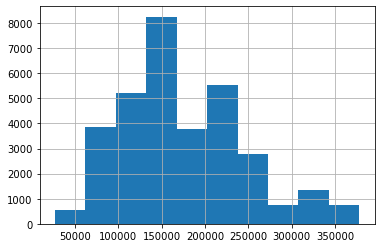

In [97]:
fig,ax = plt.subplots(figsize=[6,4])
df['AMT_INCOME_TOTAL'].hist()

In [98]:
df['AMT_INCOME_TOTAL'] = MinMaxScaler().fit_transform(df[['AMT_INCOME_TOTAL']])

In [99]:
df = df.drop(columns=['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'AGE','binned_AMT_INCOME_TOTAL', 'binned_WORK_YEAR'], axis=1)
df

,ID,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,CNT_FAM_MEMBERS,TARGET,binned_AGE,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Working,...,FAMILY_STT_Married,FAMILY_STT_Separated,FAMILY_STT_Single / not married,FAMILY_STT_Widow,HOUSING_Co-op apartment,HOUSING_House / apartment,HOUSING_Municipal apartment,HOUSING_Office apartment,HOUSING_Rented apartment,HOUSING_With parents
0,5008806,0.243590,2,2.0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
30,5008808,0.692308,2,1.0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
35,5008809,0.692308,2,1.0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
40,5008810,0.692308,2,1.0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
67,5008811,0.692308,2,1.0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689182,5149834,0.371795,3,2.0,0,2,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
689201,5149838,0.371795,3,2.0,1,2,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
689215,5149838,0.371795,3,2.0,0,2,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
689234,5150049,0.730769,2,2.0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


In [100]:
df.columns

Index(['ID', 'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'CNT_FAM_MEMBERS',
       'TARGET', 'binned_AGE', 'INCOME_TYPE_Commercial associate',
       'INCOME_TYPE_Pensioner', 'INCOME_TYPE_State servant',
       'INCOME_TYPE_Working', 'FAMILY_STT_Civil marriage',
       'FAMILY_STT_Married', 'FAMILY_STT_Separated',
       'FAMILY_STT_Single / not married', 'FAMILY_STT_Widow',
       'HOUSING_Co-op apartment', 'HOUSING_House / apartment',
       'HOUSING_Municipal apartment', 'HOUSING_Office apartment',
       'HOUSING_Rented apartment', 'HOUSING_With parents'],
      dtype='object')

# Model

### Train-Test Split

pip install imblearn

In [101]:
X = df.drop(columns=['ID', 'TARGET'],axis=1)
y = df['TARGET']

In [102]:
X.columns

Index(['AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'CNT_FAM_MEMBERS',
       'binned_AGE', 'INCOME_TYPE_Commercial associate',
       'INCOME_TYPE_Pensioner', 'INCOME_TYPE_State servant',
       'INCOME_TYPE_Working', 'FAMILY_STT_Civil marriage',
       'FAMILY_STT_Married', 'FAMILY_STT_Separated',
       'FAMILY_STT_Single / not married', 'FAMILY_STT_Widow',
       'HOUSING_Co-op apartment', 'HOUSING_House / apartment',
       'HOUSING_Municipal apartment', 'HOUSING_Office apartment',
       'HOUSING_Rented apartment', 'HOUSING_With parents'],
      dtype='object')

In [103]:
from imblearn.over_sampling import SMOTE
X_balanced,y_balanced = SMOTE().fit_resample(X,y)
X_balanced = pd.DataFrame(X_balanced, columns = X.columns)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state = 99)

In [105]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32834 entries, 0 to 689244
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AMT_INCOME_TOTAL                  32834 non-null  float64
 1   NAME_EDUCATION_TYPE               32834 non-null  int8   
 2   CNT_FAM_MEMBERS                   32834 non-null  float64
 3   binned_AGE                        32834 non-null  int32  
 4   INCOME_TYPE_Commercial associate  32834 non-null  uint8  
 5   INCOME_TYPE_Pensioner             32834 non-null  uint8  
 6   INCOME_TYPE_State servant         32834 non-null  uint8  
 7   INCOME_TYPE_Working               32834 non-null  uint8  
 8   FAMILY_STT_Civil marriage         32834 non-null  uint8  
 9   FAMILY_STT_Married                32834 non-null  uint8  
 10  FAMILY_STT_Separated              32834 non-null  uint8  
 11  FAMILY_STT_Single / not married   32834 non-null  uint8  
 12  FAM

In [109]:
X

,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,CNT_FAM_MEMBERS,binned_AGE,INCOME_TYPE_Commercial associate,INCOME_TYPE_Pensioner,INCOME_TYPE_State servant,INCOME_TYPE_Working,FAMILY_STT_Civil marriage,FAMILY_STT_Married,FAMILY_STT_Separated,FAMILY_STT_Single / not married,FAMILY_STT_Widow,HOUSING_Co-op apartment,HOUSING_House / apartment,HOUSING_Municipal apartment,HOUSING_Office apartment,HOUSING_Rented apartment,HOUSING_With parents
0,0.243590,2,2.0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
30,0.692308,2,1.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
35,0.692308,2,1.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
40,0.692308,2,1.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
67,0.692308,2,1.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689182,0.371795,3,2.0,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
689201,0.371795,3,2.0,2,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
689215,0.371795,3,2.0,2,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
689234,0.730769,2,2.0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0


### Logistic Regression

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score is 0.6345

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58      9786
           1       0.61      0.76      0.67      9757

    accuracy                           0.63     19543
   macro avg       0.64      0.63      0.63     19543
weighted avg       0.64      0.63      0.63     19543

      0     1
0  5030  4756
1  2387  7370
[[0.51399959 0.48600041]
 [0.24464487 0.75535513]]


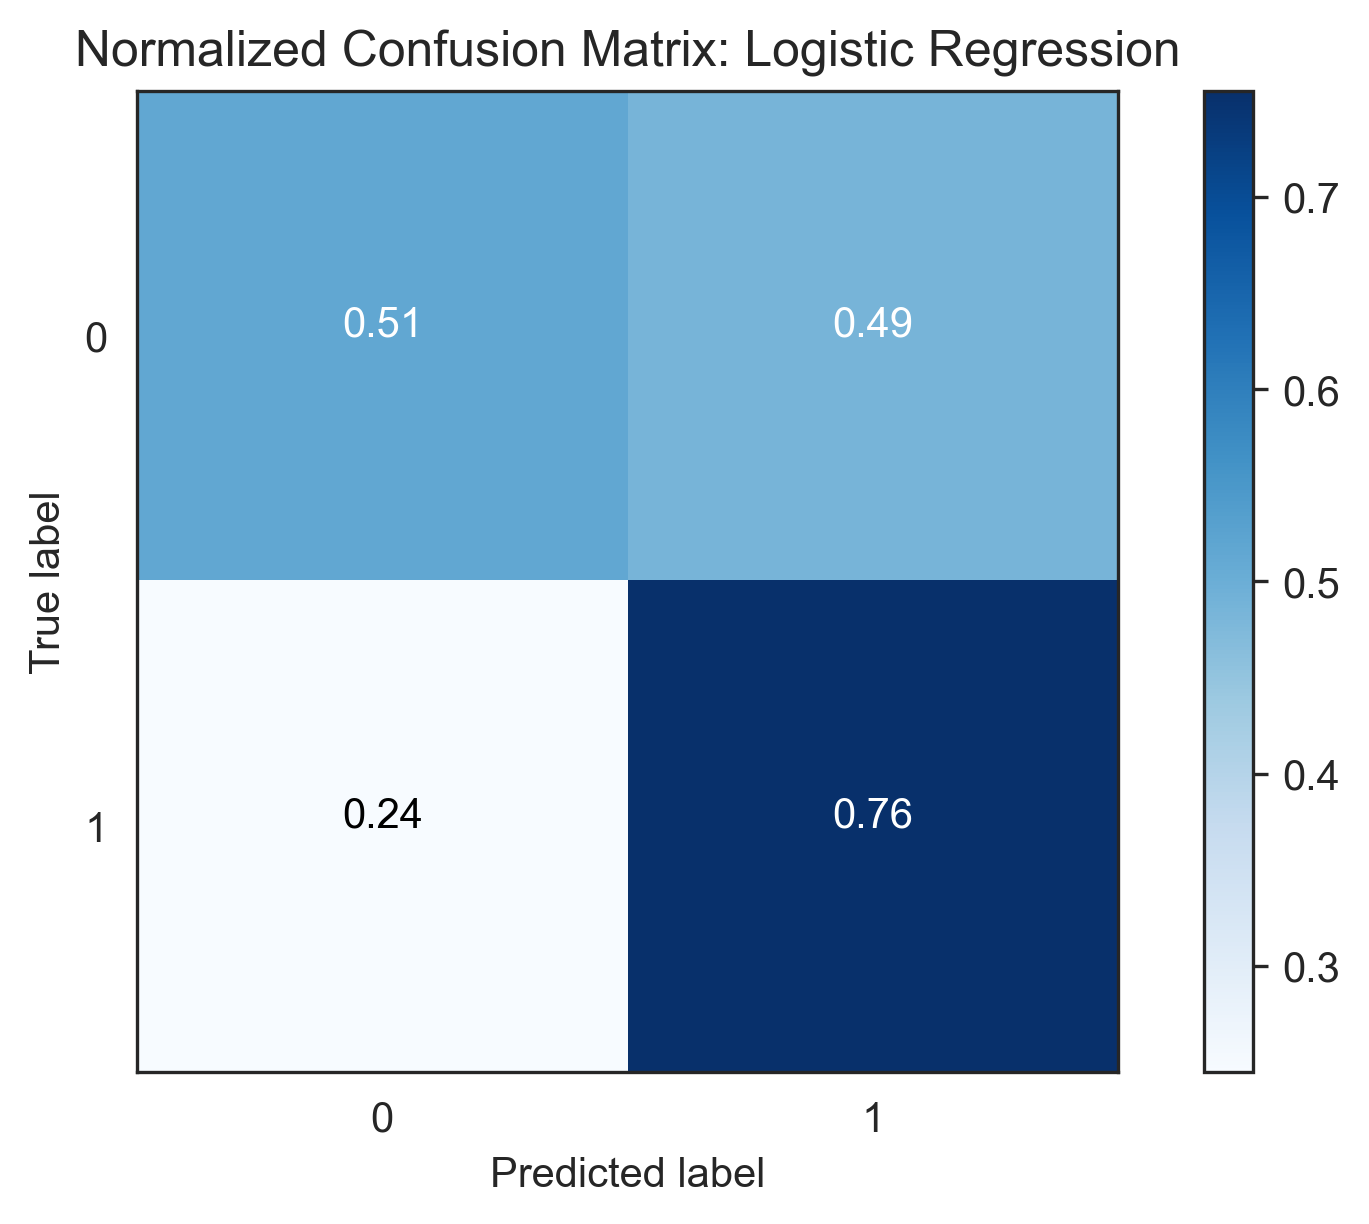

In [110]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_logreg_predict = logreg.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_logreg_predict)))
print('\nClassification report:')      
print(classification_report(y_test, y_logreg_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_logreg_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_logreg_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

### DecisionTree

Accuracy Score is 0.95999

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9786
           1       0.96      0.96      0.96      9757

    accuracy                           0.96     19543
   macro avg       0.96      0.96      0.96     19543
weighted avg       0.96      0.96      0.96     19543

      0     1
0  9370   416
1   366  9391
[[0.95749029 0.04250971]
 [0.03751153 0.96248847]]


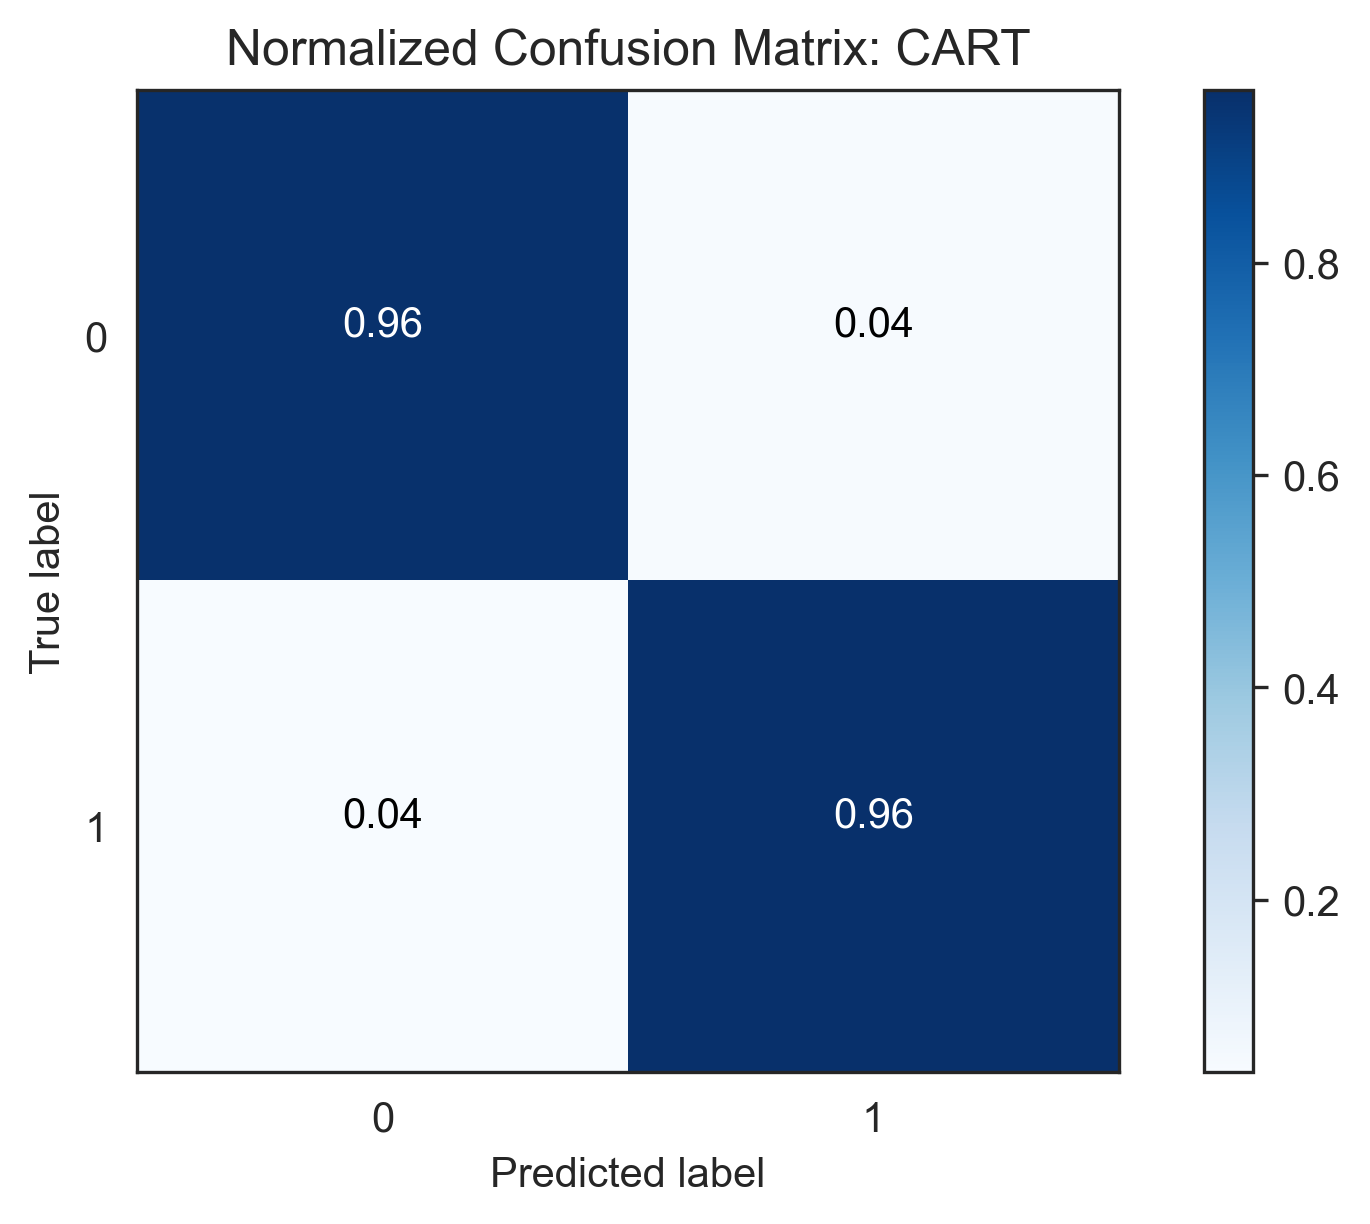

In [111]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_dtree_predict = dtree.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_dtree_predict)))
print('\nClassification report:')      
print(classification_report(y_test, y_dtree_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_dtree_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_dtree_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART')

### RandomForest

Accuracy Score is 0.95753

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      9786
           1       0.95      0.96      0.96      9757

    accuracy                           0.96     19543
   macro avg       0.96      0.96      0.96     19543
weighted avg       0.96      0.96      0.96     19543

      0     1
0  9316   470
1   360  9397
[[0.95197221 0.04802779]
 [0.03689659 0.96310341]]


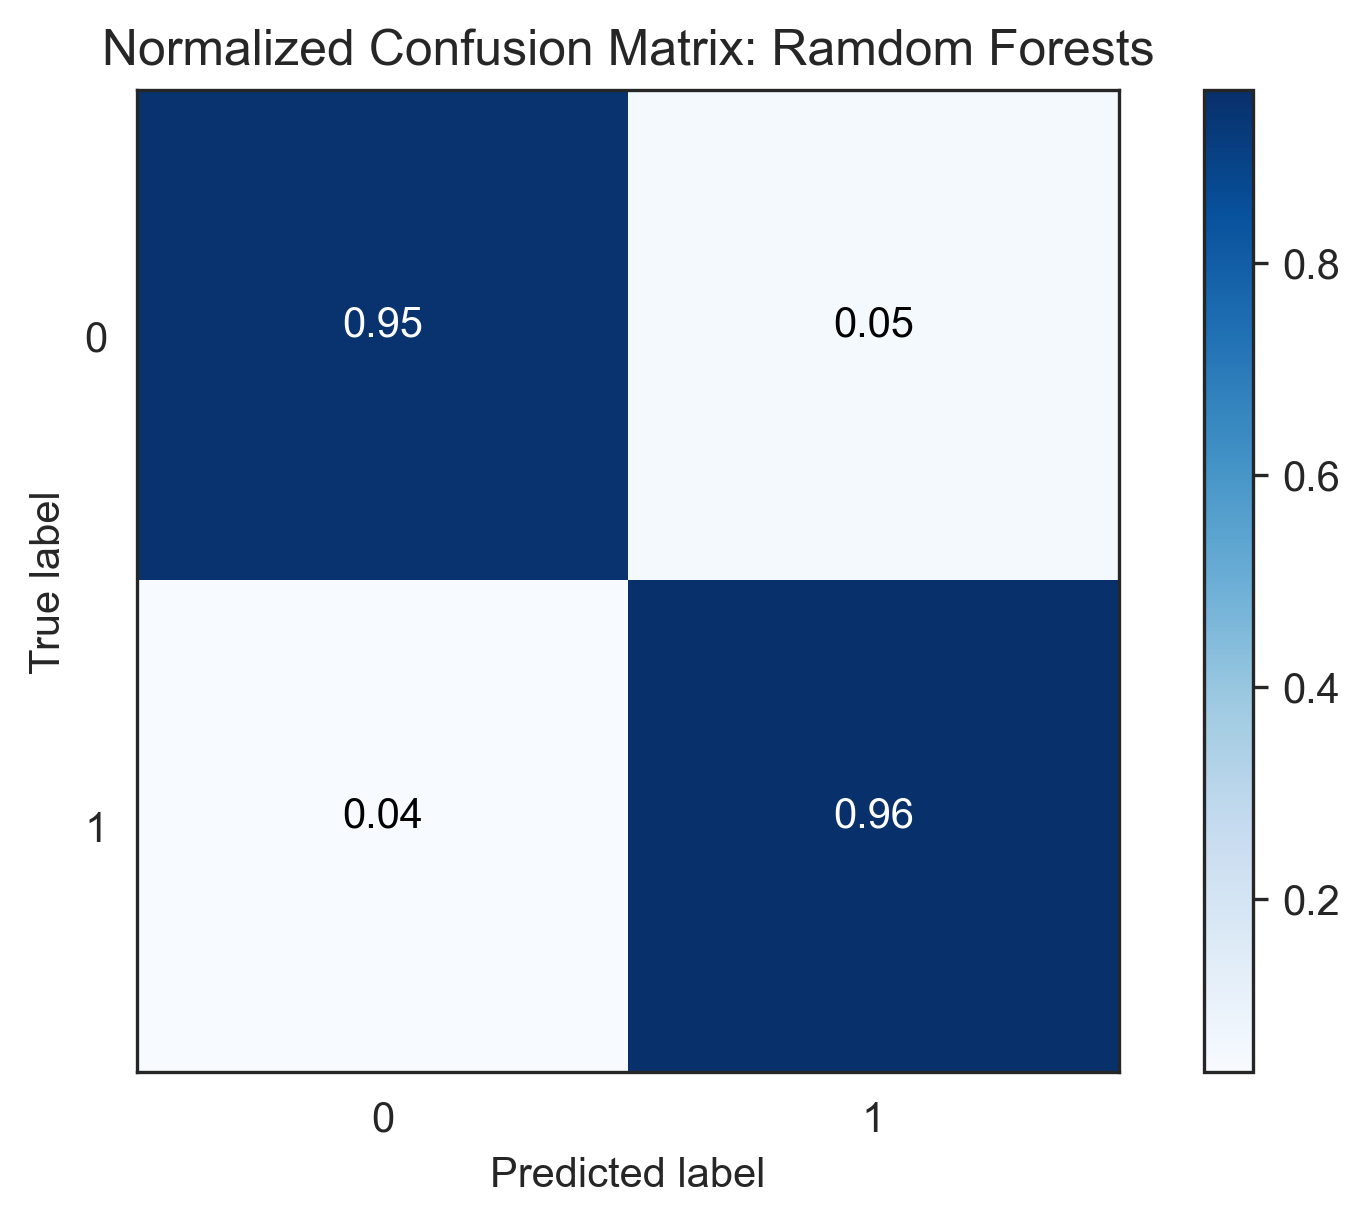

In [112]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_rf_predict = rf.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_rf_predict)))
print('\nClassification report:')      
print(classification_report(y_test, y_rf_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_rf_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_rf_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')

### LightGBM

Accuracy Score is 0.94054

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9786
           1       0.95      0.93      0.94      9757

    accuracy                           0.94     19543
   macro avg       0.94      0.94      0.94     19543
weighted avg       0.94      0.94      0.94     19543

      0     1
0  9287   499
1   663  9094
[[0.94900879 0.05099121]
 [0.06795121 0.93204879]]


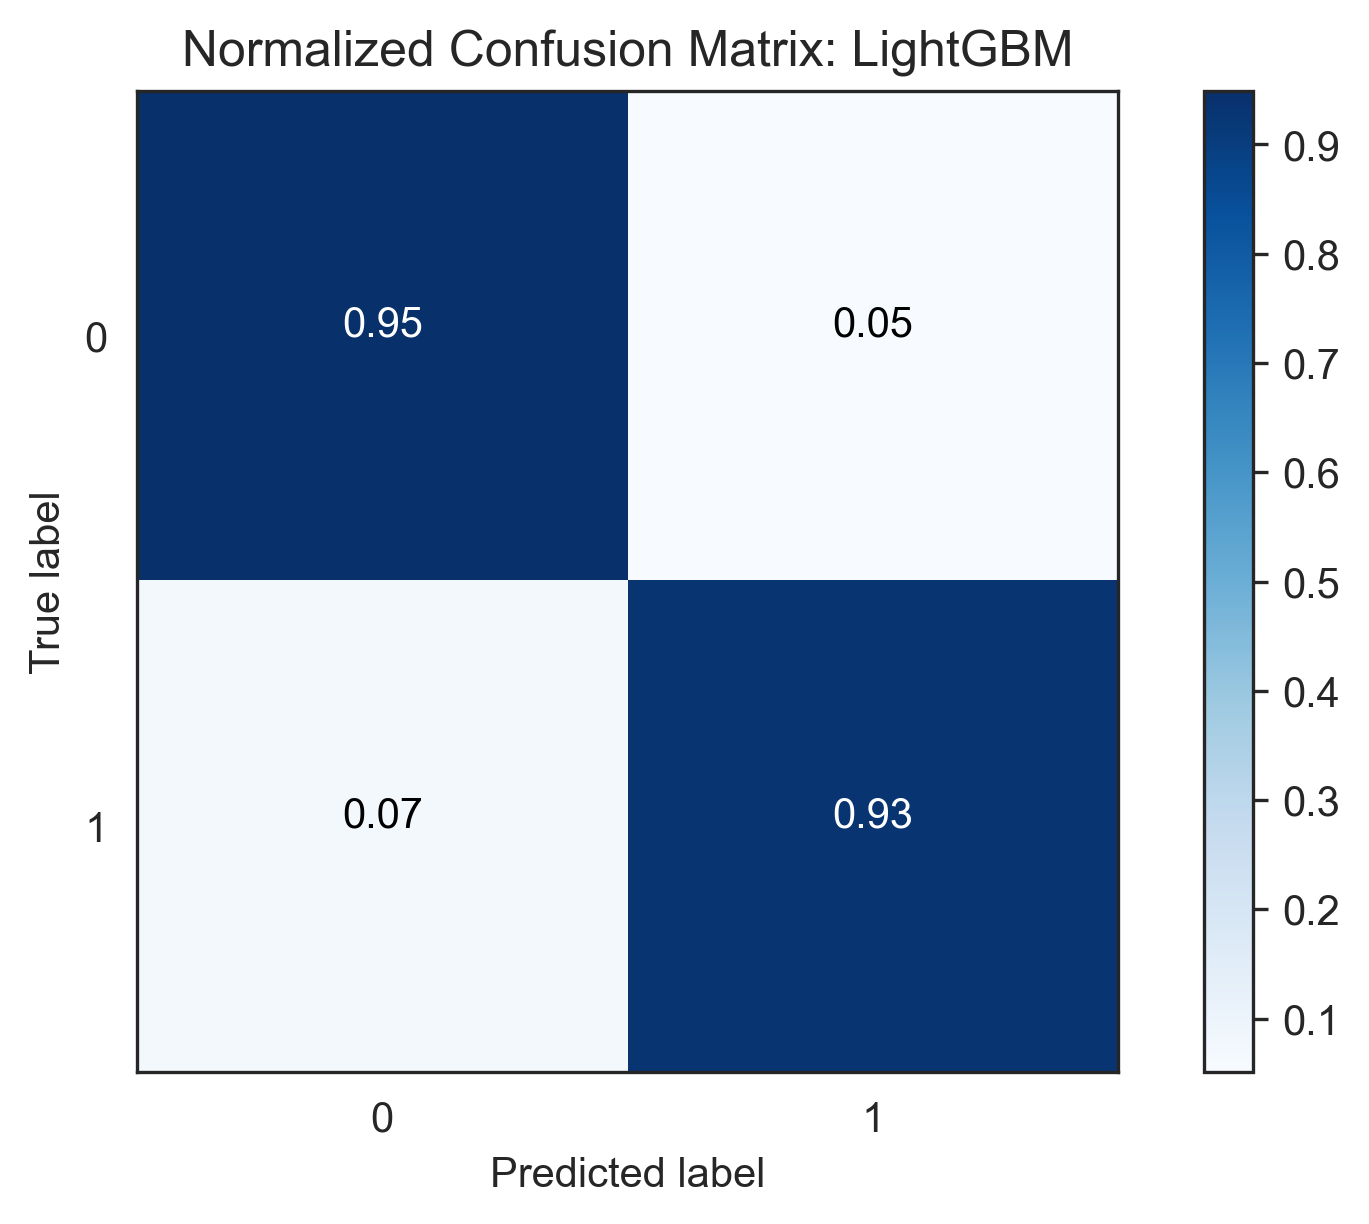

In [113]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train, y_train)
y_lightgbm_predict = lightgbm.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_lightgbm_predict)))
print('\nClassification report:')      
print(classification_report(y_test, y_lightgbm_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_lightgbm_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_lightgbm_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: LightGBM')

### XGBoost

Accuracy Score is 0.96213

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9786
           1       0.96      0.96      0.96      9757

    accuracy                           0.96     19543
   macro avg       0.96      0.96      0.96     19543
weighted avg       0.96      0.96      0.96     19543

      0     1
0  9445   341
1   399  9358
[[0.9651543  0.0348457 ]
 [0.04089372 0.95910628]]


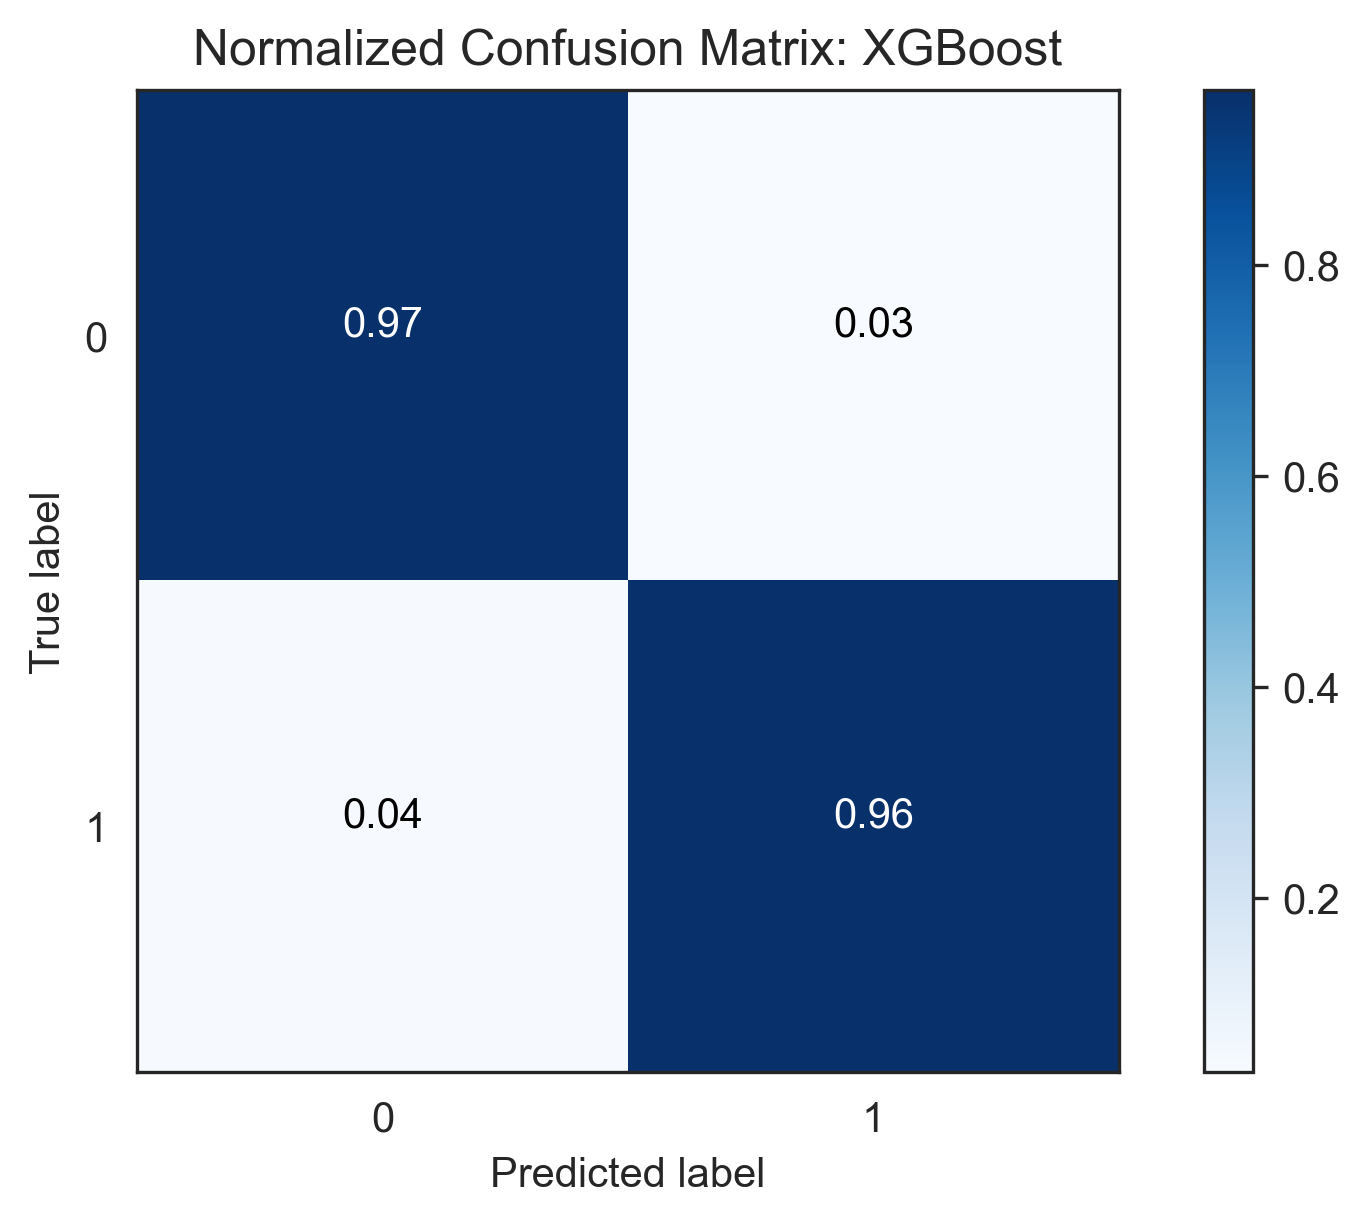

In [114]:
xgboost = XGBClassifier()

xgboost.fit(X_train, y_train)
y_xgboost_predict = xgboost.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_xgboost_predict)))
print('\nClassification report:')      
print(classification_report(y_test, y_xgboost_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_xgboost_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_xgboost_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: XGBoost')

# ROCAU graph

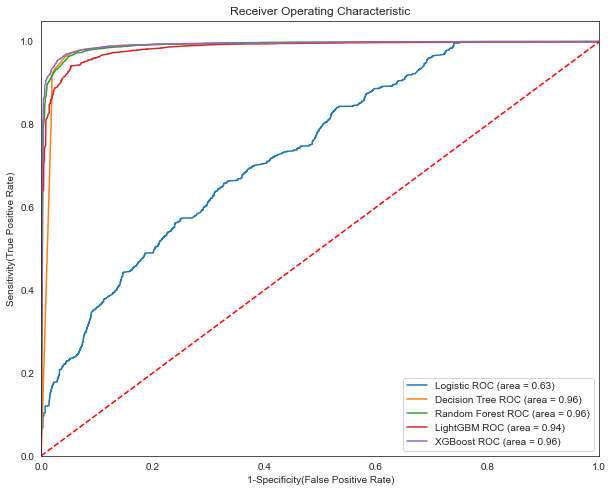

In [115]:
from sklearn import metrics

# false positive rate,fpr= FP/(TN+FP) OR fpr=1-specificty, tpr=sensitivity 
y_logreg_predict = logreg.predict_proba(X_test)[:,1]
#y_pred_svc_p = scv.predict_proba(X_test)[:,1]
y_dtree_predict = dtree.predict_proba(X_test)[:,1]
y_rf_predict = rf.predict_proba(X_test)[:,1]
y_lightgbm_predict = lightgbm.predict_proba(X_test)[:,1]
y_xgboost_predict = xgboost.predict_proba(X_test)[:,1]

model = [logreg, dtree, rf, lightgbm, xgboost]

models=[y_logreg_predict, y_dtree_predict, y_rf_predict, y_lightgbm_predict, y_xgboost_predict]
label=['Logistic', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost']

# plotting ROC curves
plt.figure(figsize=(10, 8))
m=np.arange(5)
for m in m:
    fpr, tpr,thresholds= metrics.roc_curve(y_test,models[m])
    auc = metrics.roc_auc_score(y_test,model[m].predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (label[m], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()